In [18]:
import argparse
import time
import os
from datetime import datetime, timedelta
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib


import warnings
warnings.filterwarnings('ignore')

In [21]:

def fetch_gld_data_robust(force_refresh=False, chunk_months=6, max_retries=3):
    """
    Fetch GLD 1-hour data for past 3 years in reliable chunks.
    Args:
        force_refresh (bool): force re-download even if cache exists
        chunk_months (int): size of each download chunk in months
        max_retries (int): retries per chunk if download fails
    Returns:
        pd.DataFrame: combined GLD data
    """
    cache_file = 'gld_data_1h.npy'
    cache_dates_file = 'gld_dates_1h.npy'

    # Return cached data if exists and not forcing refresh
    if not force_refresh and os.path.exists(cache_file) and os.path.exists(cache_dates_file):
        try:
            data_array = np.load(cache_file)
            dates_array = np.load(cache_dates_file, allow_pickle=True)
            dates = pd.to_datetime(dates_array)
            cached_data = pd.DataFrame(data_array,
                                       columns=['Open', 'High', 'Low', 'Close', 'Volume'],
                                       index=dates)
            print(f"Loaded cached GLD data: {len(cached_data)} rows")
            return cached_data
        except Exception as e:
            print(f"Cache load failed: {e}, fetching fresh data...")

    # Compute chunk dates
    end_date = datetime.now()
    start_date = end_date - timedelta(days=730)  # ~3 years
    chunk_starts = pd.date_range(start=start_date, end=end_date, freq=pd.DateOffset(months=chunk_months)).to_pydatetime().tolist()
    if chunk_starts[-1] < end_date:
        chunk_starts.append(end_date)

    all_chunks = []
    for i in range(len(chunk_starts) - 1):
        chunk_start = chunk_starts[i]
        chunk_end = chunk_starts[i+1]
        print(f"Downloading chunk: {chunk_start.date()} -> {chunk_end.date()}")

        retries = 0
        while retries < max_retries:
            try:
                chunk_data = yf.download('GLD', start=chunk_start, end=chunk_end, interval='1h', progress=False)
                if chunk_data.empty:
                    raise ValueError("Empty chunk data")
                # Flatten columns if needed
                if isinstance(chunk_data.columns, pd.MultiIndex):
                    chunk_data.columns = [col[0] for col in chunk_data.columns]
                # Keep required columns
                chunk_data = chunk_data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
                all_chunks.append(chunk_data)
                print(f"✓ Chunk downloaded: {len(chunk_data)} rows")
                break
            except Exception as e:
                retries += 1
                print(f"Retry {retries}/{max_retries} failed for chunk: {e}")
                time.sleep(5)  # wait 5 seconds before retry
        else:
            raise Exception(f"Failed to download chunk {chunk_start} -> {chunk_end} after {max_retries} retries")

    # Concatenate all chunks
    gld = pd.concat(all_chunks)
    gld = gld[~gld.index.duplicated(keep='first')]  # remove duplicate timestamps

    # Save to cache
    try:
        np.save(cache_file, gld.values)
        np.save(cache_dates_file, gld.index.strftime('%Y-%m-%d %H:%M:%S').values)
        print(f"Saved combined GLD data to cache: {len(gld)} rows")
    except Exception as e:
        print(f"Warning: Could not save cache: {e}")

    gld.to_csv('dataset.csv', index=False)
    return gld


In [22]:
gld_data = fetch_gld_data_robust()
gld_data.head()

✓ Chunk downloaded: 871 rows
✓ Chunk downloaded: 885 rows
✓ Chunk downloaded: 853 rows
✓ Chunk downloaded: 878 rows
Saved combined GLD data to cache: 3487 rows


,Open,High,Low,Close,Volume
Datetime,,,,,
2023-09-19 13:30:00+00:00,179.539993,179.649994,179.139999,179.205002,1310839
2023-09-19 14:30:00+00:00,179.199997,179.550003,179.160095,179.384995,712985
2023-09-19 15:30:00+00:00,179.384995,179.419907,179.250000,179.338501,359622
2023-09-19 16:30:00+00:00,179.335007,179.335007,179.119995,179.300003,273955
2023-09-19 17:30:00+00:00,179.300003,179.339996,179.029999,179.115005,268654


In [23]:
def load_dataset() -> pd.DataFrame:
    path = 'dataset.csv'
    df = pd.read_csv(path, parse_dates=['Datetime'])
    print("*"*15 +  " DATASET INFO: " + "*"*15 + f"\n {df.info()}")
    print("*"*15 +  " DATASET HEAD: " + "*"*15 + f"\n {df.head()}")
    print("*"*15 +  " NUMBER OF ROWS: " + "*"*15 + f"\n {len(df)}")

    return df

In [24]:
df = load_dataset()

ValueError: Missing column provided to 'parse_dates': 'Datetime'

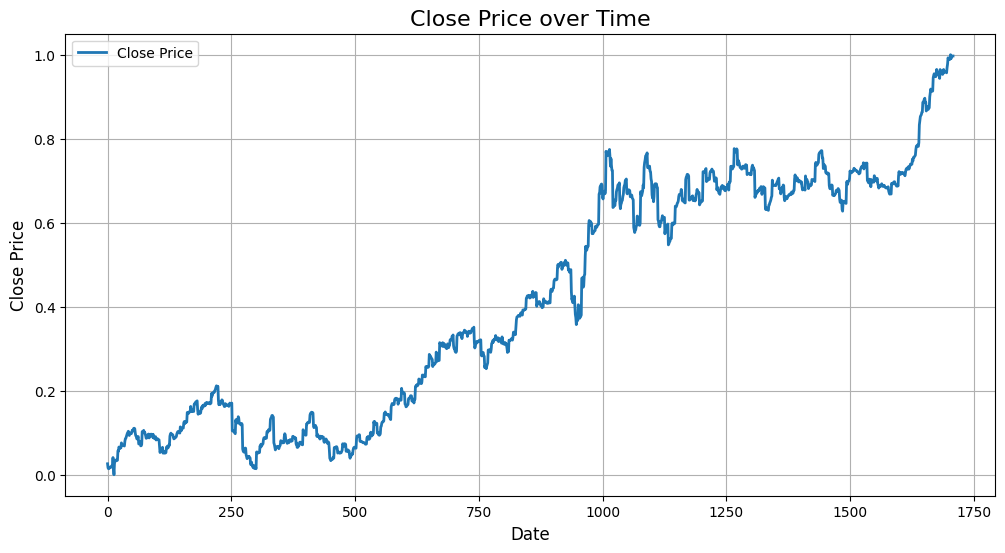

In [25]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Close"], label="Close Price", linewidth=2)
plt.title("Close Price over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [26]:
def scale_dataset(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    features = [col for col in df.columns if col not in ['Datetime', 'Close']]
    target = 'Close'

    df[features] = feature_scaler.fit_transform(df[features])
    df[target] = target_scaler.fit_transform(df[[target]])

    df.to_csv('../scaled_dataset.csv', index=False)

    print("*"*15 +  " DATASET HEAD: " + "*"*15 + f"\n {df.head()}")

    joblib.dump(feature_scaler, 'scalers/feature_scaler.pkl')
    joblib.dump(target_scaler, 'scalers/target_scaler.pkl')

    return df

In [27]:
df_scaled = scale_dataset(df)

*************** DATASET HEAD: ***************
                    Datetime     Close      SMA7  SMA20     SMA50   SMA200  \
0 2024-09-17 13:30:00+00:00  0.026059  0.001216    0.0  0.005111  0.02373   
1 2024-09-17 14:30:00+00:00  0.016383  0.001216    0.0  0.005111  0.02373   
2 2024-09-17 15:30:00+00:00  0.014179  0.001216    0.0  0.005111  0.02373   
3 2024-09-17 16:30:00+00:00  0.014658  0.001216    0.0  0.005111  0.02373   
4 2024-09-17 17:30:00+00:00  0.018011  0.001216    0.0  0.005111  0.02373   

      EMA21     EMA50    EMA200     RSI14  ...  Vol_Ratio       OBV  \
0  0.009027  0.009172  0.010454  0.308031  ...   0.160677  0.063837   
1  0.003766  0.003867  0.004436  0.308031  ...   0.160677  0.060330   
2  0.001181  0.001278  0.001512  0.308031  ...   0.160677  0.056946   
3  0.000037  0.000121  0.000201  0.308031  ...   0.160677  0.060319   
4  0.000190  0.000207  0.000261  0.308031  ...   0.160677  0.062891   

   Price_Change  Price_Momentum_5  Price_Momentum_20  Trend_Str

In [28]:
class ProfessionalLSTM(nn.Module):
    def __init__(self, input_size=20, hidden_size=128, num_layers=3, dropout=0.3):
        super(ProfessionalLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout, bidirectional=True
        )
        self.attention = nn.MultiheadAttention(hidden_size * 2, num_heads=8, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_size // 2, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

    def forward(self, x):
        device = x.device
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size, device=device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size, device=device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_out_transposed = lstm_out.transpose(0, 1)  
        attn_out, _ = self.attention(lstm_out_transposed, lstm_out_transposed, lstm_out_transposed)
        attn_out = attn_out.transpose(0, 1) 
        lstm_out = self.layer_norm(lstm_out + attn_out)
        context = torch.mean(lstm_out, dim=1)
 
        out = self.relu(self.fc1(context))
        out = self.dropout1(out)
        # residual = out
        
        out = self.relu(self.fc2(out))
        out = self.dropout2(out)
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        
        return out

In [29]:
def create_professional_lstm(input_size=20, hidden_size=128, num_layers=3, dropout=0.3):
    return ProfessionalLSTM(input_size, hidden_size, num_layers, dropout)

**CODE BY GPT**

Sequences shape: X=(1689, 20, 38), y=(1689,)
Epoch 1/150, Train Loss: 0.022840, Val Loss: 0.001539
Epoch 2/150, Train Loss: 0.006280, Val Loss: 0.002299
Epoch 3/150, Train Loss: 0.004710, Val Loss: 0.003290
Epoch 4/150, Train Loss: 0.005656, Val Loss: 0.001852
Epoch 5/150, Train Loss: 0.003942, Val Loss: 0.001536
Epoch 6/150, Train Loss: 0.003204, Val Loss: 0.003766
Epoch 7/150, Train Loss: 0.002945, Val Loss: 0.004741
Epoch 8/150, Train Loss: 0.002732, Val Loss: 0.002004
Epoch 9/150, Train Loss: 0.002710, Val Loss: 0.004413
Epoch 10/150, Train Loss: 0.002316, Val Loss: 0.005164
Epoch 11/150, Train Loss: 0.002480, Val Loss: 0.002357
Epoch 12/150, Train Loss: 0.002134, Val Loss: 0.005503
Epoch 13/150, Train Loss: 0.002055, Val Loss: 0.002736
Epoch 14/150, Train Loss: 0.002169, Val Loss: 0.004761
Epoch 15/150, Train Loss: 0.002211, Val Loss: 0.005410
Epoch 16/150, Train Loss: 0.002001, Val Loss: 0.004470
Epoch 17/150, Train Loss: 0.001831, Val Loss: 0.004930
Epoch 18/150, Train Loss: 0.0

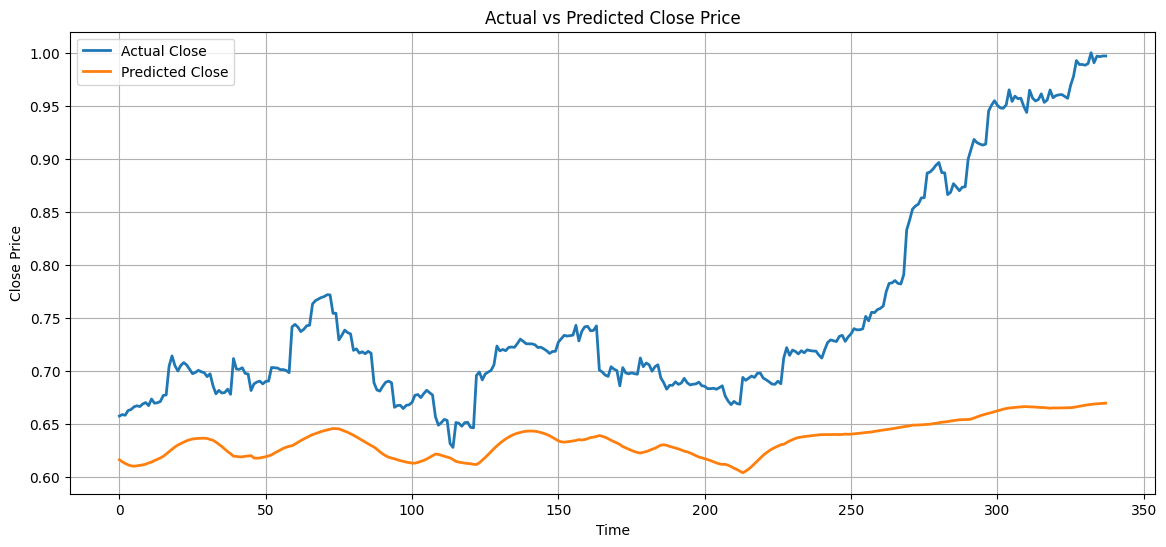

In [31]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# -------------------------
# 1. Helper: Create sequences (lag features included)
# -------------------------
def create_sequences(data, target_column='Close', seq_length=20):
    X, y = [], []
    data_values = data.values
    target_idx = data.columns.get_loc(target_column)
    for i in range(len(data) - seq_length):
        X.append(data_values[i:i+seq_length])
        y.append(data_values[i+seq_length, target_idx])
    return np.array(X), np.array(y)

# -------------------------
# 2. Load numeric dataset
# -------------------------
df = df_scaled.copy()
numeric_cols = df.select_dtypes(include=np.number).columns
df_numeric = df[numeric_cols]

SEQ_LENGTH = 20
X, y = create_sequences(df_numeric, target_column='Close', seq_length=SEQ_LENGTH)
print(f"Sequences shape: X={X.shape}, y={y.shape}")

# -------------------------
# 3. Train-test split (80/20)
# -------------------------
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# -------------------------
# 4. Validation split
# -------------------------
val_size = int(0.1 * len(X_train))
train_size = len(X_train) - val_size
train_dataset, val_dataset = random_split(TensorDataset(X_train, y_train), [train_size, val_size])
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

# -------------------------
# 5. Model
# -------------------------
model = create_professional_lstm(input_size=X.shape[2], hidden_size=128, num_layers=2, dropout=0.3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# -------------------------
# 6. Training loop with early stopping
# -------------------------
EPOCHS = 150
best_val_loss = np.inf
patience = 15
counter = 0

for epoch in range(1, EPOCHS+1):
    # Training
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(model(xb), yb).item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch}/{EPOCHS}, Train Loss: {epoch_loss:.6f}, Val Loss: {val_loss:.6f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_professional_lstm.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# -------------------------
# 7. Load best model
# -------------------------
model.load_state_dict(torch.load('best_professional_lstm.pth'))

# -------------------------
# 8. Predictions
# -------------------------
model.eval()
y_pred = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        pred = model(xb)
        y_pred.append(pred.cpu().numpy())
y_pred = np.concatenate(y_pred, axis=0)

# -------------------------
# 9. Inverse transform using scaler
# -------------------------
target_scaler = joblib.load('scalers/target_scaler.pkl')
y_test_inv = target_scaler.inverse_transform(y_test.numpy())
y_pred_inv = target_scaler.inverse_transform(y_pred)

# -------------------------
# 10. Metrics
# -------------------------
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_inv - y_pred_inv)/y_test_inv)) * 100

print(f"R2 Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# -------------------------
# 11. Plot results
# -------------------------
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual Close', linewidth=2)
plt.plot(y_pred_inv, label='Predicted Close', linewidth=2)
plt.title("Actual vs Predicted Close Price")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()
